# Tutorial 2 - Convolutional Neural Network (CNN)

Data Science for Business II D,
Aalto University School of Business

In this tutorial, you will learn how to train a simple **Convolutional Neural Network (CNN)** using a Python library named `PyTorch`. The `PyTorch` library is an open-source machine learning library for Python, used for a variety of applications such as image classification and natural language processing. We will use the implemented neural network to learn to again classify images of fashion articles from the **FashionMNIST** dataset.


The figure below illustrates a high-level view of the machine learning process we aim to establish in this notebook:

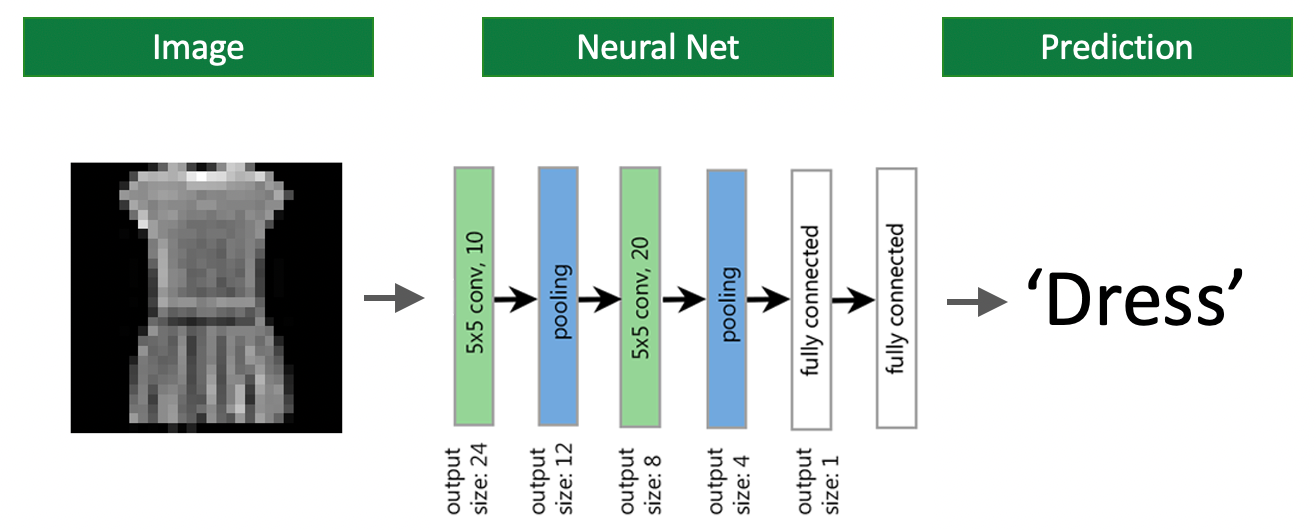

You can learn more about the PyTorch at:
* [PyTorch](https://pytorch.org/)

You can learn more about this dataset at:
* [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist)

## 1. Tutorial objectives

After today's tutorial, you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **Convolutional Neural Networks (CNN)**.
> 2. Know how to use Python's **PyTorch library** to train and evaluate neural network based models.
> 3. Understand how to apply neural networks to **classify images** of fashion items.
> 4. Know how to **evaluate the networks classification performance**.

Before we start let's watch a motivational video:

In [ ]:
from IPython.display import YouTubeVideo
# The Deep Learning Revolution"
YouTubeVideo('Dy0hJWltsyE', width=800, height=400)

## 2. Setup of the Jupyter Notebook Environment

At first, we need to import a couple of Python libraries that allow for data analysis and deep learning.

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Import `Google's GDrive` connector and mount your `GDrive` directories:

In [ ]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Create a structure of `Colab` Notebook sub-directories inside of `GDrive` to to store the data and the trained neural network models:

In [ ]:
# create Colab Notebooks directory
notebook_directory = '/content/drive/MyDrive/Colab Notebooks'
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

 # create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/data_fmnist'
if not os.path.exists(data_directory): os.makedirs(data_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = '/content/drive/MyDrive/Colab Notebooks/models_fmnist'
if not os.path.exists(models_directory): os.makedirs(models_directory)

Set a random `seed` value to obtain reproducable results:

In [ ]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed

Google Colab provides the use of free GPUs for running notebooks. However, if you just execute this notebook as is, it will use your device's CPU. To run the notebook on a GPU, got to `Runtime` > `Change runtime type` and set the Runtime type to `GPU` in the drop-down. Running this notebook on a CPU is fine, but you will find that GPU computing is faster. *CUDA* indicates that the notebook is being run on GPU.

Why we use GPU for training the CNN?
- GPUs are massively parallel devices that can execute thousands of threads at the same time.
* See examples and video at: [GPU Programming](https://carpentries-incubator.github.io/lesson-gpu-programming/introduction.html)

Enable GPU computing by setting the device flag and init a CUDA seed:

In [ ]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu').type

# init deterministic GPU and CPU seed
torch.manual_seed(seed_value) # set pytorch seed

# log type of device enabled

print('[LOG] notebook with {} computation enabled'.format(str(device)))

Let's determine if we have access to a GPU provided by e.g. `Google's Colab` environment:

In [ ]:
!nvidia-smi

## 3. FashionMNIST database

The **FashionMNIST database** is a large database of Zalando articles that is commonly used for training various image processing systems. The database is widely used for training and testing in the field of machine learning. Let's have a brief look into a couple of sample images contained in the dataset:

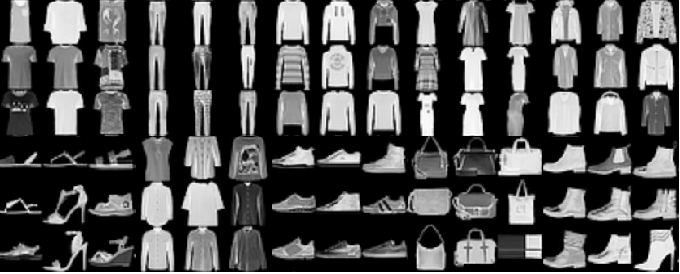

Further details on the dataset can be obtained via Zalando research's [github page](https://github.com/zalandoresearch/fashion-mnist).

The dataset is divided into a set of **60,000 training examples** and a set of **10,000 evaluation examples**. Each example is a **28x28 grayscale image**, associated with a **label from 10 classes**: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

Zalando created this dataset with the intention of providing a replacement for the popular **MNIST** handwritten digits dataset. It is a useful addition as it is a bit more complex, but still very easy to use. It shares the same image size and train/test split structure as MNIST, and can therefore be used as a drop-in replacement. It requires minimal efforts on preprocessing and formatting the distinct images.

However, the image data does not always come in its final processed form that is required for training machine learning algorithms. We need to transform the data to tensors that are suitable for training. Let's download, transform and inspect the training images of the dataset.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

# download the dataset
trainset = torchvision.datasets.FashionMNIST(root=data_directory, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_directory, train=False, download=True, transform=transform)

# define the labels of the images
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# specify the batch size for training and test
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

In [ ]:
# determine the number of training data images
len(trainset)

In [ ]:
# determine the number of test data images
len(testset)

Great, let's now visually inspect our sample image:

In [ ]:
# define a function for plot
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)

In [ ]:
images, labels = next(iter(trainloader))
plot_images(images[:8], n_rows=2)

## 4. Neural Network Implementation

**CNN**

Now, we will implement the architecture of the **CNN**. We aim to learn a model that is capable of classifying the 28x28 pixel FashionMNIST images according to the objects contained in each image.

The architecture:
- One convolutional layer with:
    - 5x5 kernel
    - 10 output channels
    - *no padding*
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- One convolutional layer with:
    - 5x5 kernel
    - 20 output channels
    - *no padding*
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- A block of two linear layers with ReLU nonlinearity with:
    - linear layers with 20x4x4 inputs and 80 outputs
    - ReLU nonlinearity
    - linear layers with 80 inputs and 10 outputs

Notes:
* We recommend that you check the number of modules with trainable parameters in your network.

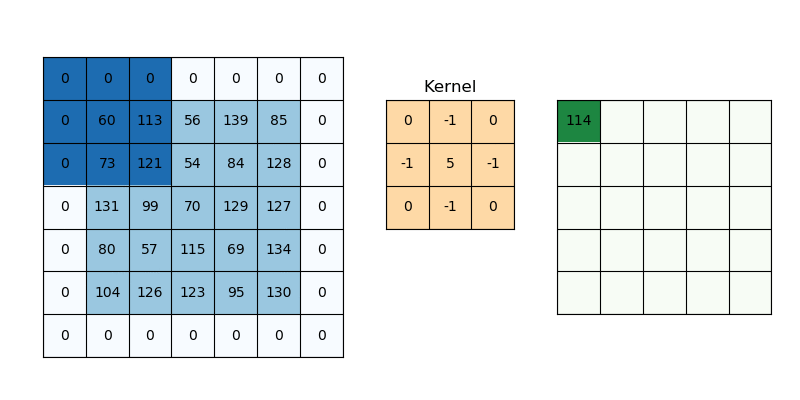

In [ ]:
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()

        self.convolutional_layer = nn.Sequential(

            # convolutional layer 1
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU(inplace=True),

            # max pooling layer 1
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolutional layer 2
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),

            # max pooling layer 2
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=20*4*4, out_features=80),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=80, out_features=10),
        )

    def forward(self, x, verbose=False):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
          verbose: True if you want to print the shapes of the intermediate variables.

        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        x = self.convolutional_layer(x)
        x = x.view(-1, 20*4*4)
        x = self.linear_layer(x)
        return x

Let us check the shape of the output in our neural networks!

In [ ]:
def test_Net_shapes():
    net = FashionNet()
    net.to(device)

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = next(iter(trainloader))
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)

        y = net(images, verbose=True)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), f"Bad y.shape: {y.shape}"

    print('Success')

test_Net_shapes()

Now, that we have implemented our first neural network we are ready to instantiate a network model to be trained:

In [ ]:
net = FashionNet()

Let's push the initialized `FashionNet` model to the computing `device` that is enabled:

In [ ]:
net = net.to(device)

Let's double check if our model was deployed to the GPU:

In [ ]:
!nvidia-smi

## 5. Neural Network Model Training

In this section, we will train our neural network model (as implemented in the section above) using the transformed images of fashion items. More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

Set the hyperparameters:
* Adam optimizer with learning rate 0.001.
  - Other optimizers could be used in training, see some interesting comparative experiments by [fast.ai](https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html).
  - One simple way to choose the learning rate is to try different values from 0.0001 to 1 and observe their effects on the training process. Or you can do cross-validation and find an optimal hyperparameter.
* Cross-entropy loss.
  - Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10.
  - The number of epochs usually depends on the validation and training errors. As long as they both keep dropping we can increase the number of epochs.
  - But a large number of epochs may lead to overfitting. For instance, the validation error starts increasing. In this case, we can use early stopping to reduce the risk of overfitting.

We recommend you to use function `compute_accuracy()` defined blow to track the accaracy during training. The test accuracy should be above 0.89.

**Note: function `compute_accuracy()` sets the network into the evaluation mode which changes the way the batch statistics are computed in batch normalization. You need to set the network into the training mode (by calling `net.train()`) when you want to perform training.**

Reference: Zhang, C., Bengio, S., Hardt, M., Recht, B., & Vinyals, O. (2021). Understanding deep learning (still) requires rethinking generalization. Communications of the ACM, 64(3), 107-115.

In [ ]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
# define the optimization criterion / loss function
ce_loss = nn.CrossEntropyLoss()

# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate)

# init collection of training epoch losses
train_losses = []

# set the model in training mode
net.train()

# set the number of epochs
epochs = 10

# Implement the training loop
for epoch in range(epochs):

    # init the time
    time0 = time.time()

    # init collection of mini-batch losses
    running_loss=[]

    # iterate over all-mini batches
    for batch_idx, data in enumerate(trainloader,0):

        # push mini-batch data to computation device
        inputs,target = data
        inputs,target = inputs.to(device), target.to(device)

        # run forward pass through the network
        outputs = net(inputs)

        # reset graph gradients
        optimizer.zero_grad()

        # determine classification loss
        loss = ce_loss(outputs,target)

        # run backward pass to update the weights
        loss.backward()

        # update network paramaters
        optimizer.step()

        # collect mini-batch reconstruction loss
        running_loss.append(loss.item())

    # determine mean min-batch loss of epoch
    train_loss = np.mean(running_loss)
    train_losses.append(train_loss)

    # print epoch loss
    if epoch % 1 == 0:
        print(
            f"epoch:{epoch+1}",
            "\ttrain_loss:",
            round(train_loss, 3),
            "\taccuracy:",
            round(compute_accuracy(net, testloader),3),
            "\tUsed_time:",
                round((time.time()-time0)/60,3)
        )

Upon successfully training let's visualize and inspect the training loss per epoch:

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_losses)+1)), train_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Ok, fantastic. The training error is nicely going down. We could train the network a couple more epochs until the error converges.

But it is a sign of overfitting if the training error is very small but the test error is large. You can try to use early stopping in the **Assignment 2**.

So, let's stay with the 10 training epochs for now and continue with evaluating our trained model.

## 6. Neural Network Model Evaluation

Prior to evaluating our model, let's save and load the trained model which is the last model that we saved after 10 epochs.

In [ ]:
model_name = '2_fashion_net.pth'
torch.save(net.state_dict(), os.path.join(models_directory, model_name))

In [ ]:
model = FashionNet()

In [ ]:
# load pre-trained models
model.load_state_dict(torch.load(os.path.join(models_directory, model_name), map_location=torch.device('cpu')))

Let's inspect if the model was loaded successfully:

In [ ]:
# set model in evaluation mode
model.eval()

Let's now inspect a few sample predictions to get an impression of the model quality. Therefore, we will again pick a random image of our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:



In [ ]:
# set (random) image id
image_id = 666

# retrieve image exhibiting the image id
eval_image, eval_label = testset[image_id]

Let's now inspect the true class of the image we selected:

In [ ]:
# the true label of the image
classes[eval_label]

Ok, the randomly selected image should contain a dress. Let's inspect the image accordingly:

In [ ]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title
plt.title('Example: {}, Label: {}'.format(str(image_id), str(classes[eval_label])))

# un-normalize cifar 10 image sample
eval_image_plot = eval_image / 2.0 + 0.5

# plot cifar 10 image sample
plt.imshow(trans(eval_image_plot))

Let's predict the label of the image using our trained model:

In [ ]:
# predict the label of the random image
most_probable = torch.max(model(eval_image.unsqueeze(0)).data, 1)[1].item()
print('Most probable class: {}'.format(most_probable))
print('This class represents the following fashion article: {}'.format(classes[most_probable]))

Let's now obtain the predictions for all the fashion item images on the whole test data:

In [ ]:
# store the predicted classes on the test set
predictions = []
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

Furthermore, let's obtain the overall classifcation accuracy:

In [ ]:
# Compute the accuracy on the test set
accuracy = metrics.accuracy_score(testset.targets, predictions)
print(f'Accuracy of the FashionNet on the test images: {accuracy: .3f}')

Let's also inspect the confusion matrix to determine major sources of misclassification:

In [ ]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(testset.targets, predictions)

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=classes, yticklabels=classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('FashionMnist classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]')

Ok, we can easily see that our current model confuses T-shirt/top with shirt.
This mistake is not very surprising, as these items exhibit a high similarity.

## 7. Tutorial Summary:

In this tutorial, a step by step introduction into **design, implementation, training and evaluation** of CNNs to classify images of objects is presented. The code and exercises presented in this tutorial may serves as a starting point for developing more complex, deeper and more tailored CNNs.

CNN is particularlly powerful in the tasks of **images classification**. For other tasks, i.e., text analysis, image generation, and photo enhancer, other deep learning models could be much better. The big language model, such as GPT by OpenAi, is reshaping the way we work, live, and study.

In assignment 2, you will develop the **VGGNet**: a popular deep convolutional neural network proposed by K. Simonyan and A. Zisserman in 2014. VGGNet is deeper and better than the CNN demonstrated in this tutorial.

Email: zhiqiang.liao@aalto.fi